<h1>Multivariate Gaussian density </h1>

The Multivariate Gaussian (MVG) density is defined as: <br>
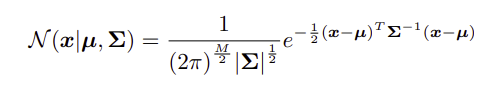 <br>

where M is the size of the feature vector x, and |Σ| is the determinant of Σ.
To avoid numerical issues due to exponentiation of large numbers, in many practical cases it’s more
convenient to work with the logarithm of the density, which is defined as: <br>
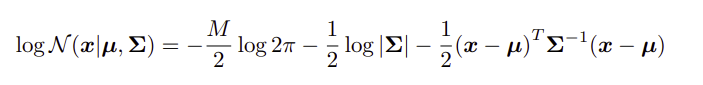 <br>

The aim is to write a function `logpdf_GAU_ND(x, mu, C)`, to calculate the log density. x is a **single sample** belonging to the dataset, mu should
be a numpy array of shape (M, 1), whereas C is a numpy array of shape (M, M) representing the
covariance matrix Σ. <br>
**At the end, to plot the actual density, pdf, I just have to perform:** $exp(log(pdf)) = pdf$

In [2]:
import numpy as np

In [3]:
#Prerequisite functions, used in previous labs:
def vcol(x):
    return x.reshape((x.size, 1))

def vrow(x):
    return x.reshape((1, x.size))

def compute_mu_C(D):
    mu = vcol(D.mean(1))
    C = ((D-mu) @ (D-mu).T) / float(D.shape[1])
    return mu, C

In [4]:
def logpdf_GAU_ND_singleSample(x, mu, C):
    #Compute the log of the probability density function of a multivariate Gaussian distribution
    """
    Parameters
    - x: numpy array of shape (M, 1) -> it's a single sample having M features.
         x is a column vector!
    - mu: numpy array of shape (M,) -> mean of the distribution
    - C: numpy array of shape (M,M) -> covariance matrix of the distribution

    Returned values:
    - logpdf: float -> the log of the probability density function of the multivariate Gaussian distribution
    """

    #Since x is a columns vector of shape (M, 1):
    M = x.shape[0]  #M is the number of features

    #Compute te inverse of the covariance matrix
    C_inv = np.linalg.inv(C)

    #Compute the log of the determinant of the covariance matrix
    #the function np.linalg.slogdet returns a tuple (sign, logdet)
    #the first element of the tuple is the sign of the determinant, which is positive for covariance matrices, and which is not needed here
    #the second element of the tupe is the log determinant of C
    C_logDet = np.linalg.slogdet(C)[1]

    #return -0.5 * M * np.log(2*np.pi) - 0.5 *C_logDet - 0.5 * (x-mu).T @ C_inv @ (x-mu)
    return -0.5 * (M * np.log(2*np.pi) + C_logDet + (x-mu).T @ C_inv @ (x-mu))

Now, it's possible to extend this function to the case where we have X which is a matrix of shape $M × N$ containing multiple samples $[x_1, x_2, ...., x_N]$. <br>
It can be convenient to write the function `logpdf_GAU_ND(X, mu, C)` so that it takes as argument a $M × N$ matrix X rather than a single sample x, and computes the vector of log-densities
$Y = [log N (x_1|µ, Σ). . . log N (x_N |µ, Σ)]$:

In [ ]:
def logpdf_GAU_ND_Loop(X, mu, C):
    #Compute the log of the probability density function of a multivariate Gaussian distribution
    """
    Parameters
    - X: numpy array of shape (M, N) -> it contains multiple samples [x1, x2, ..., xN] having M features.
         X is a matrix of shape (M, N)!
    - mu: numpy array of shape (M,) -> mean of the distribution
    - C: numpy array of shape (M,M) -> covariance matrix of the distribution

    Returned values:
    - logpdf: float -> the log of the probability density function of the multivariate Gaussian distribution
    """

    #Attempt 1: Using a loop
    #Loop over all teh samples and for each sample call the function logpdf_GAU_ND_singleSample
    N = X.shape[1]
    result = []

    for i in range(N):
        #print("Shape of X[:, i]:", X[:, i].shape) #-> it must always be (M,) 
        result.append(logpdf_GAU_ND_singleSample(X[:, i], mu, C))

    #return a numpy array and not a list
    """
    The list is structured as follows, for ex:
    [[[-21.51551212]],

     [[-21.42552223]],

     ....]

     So I have to flatten it to get a 1D array. Do I use flatten() or ravel()?
    - flatten is a method of an ndarray object and hence can only be called for true numpy arrays.
    - ravel is a library-level function and hence can be called on any object that can successfully be parsed.

     For example ravel will work on a list of ndarrays, while flatten is not available for that type of object.
     In this case, both will work, but ravel is more general and hence recommended.
    """
    
    #At the end, I return a np array of shape (N, 1) because I iterated N times (because I got N samples) and for each iteration I got a scalar value
    
    return np.array(result).ravel()

### Test with sample data

In [6]:
import matplotlib.pyplot as plt

In [7]:
XPlot = np.linspace(-8, 12, 1000)    #Shape (1000,)
XPlot = vrow(XPlot)                  #Shape (1, 1000)
m = np.ones((1,1)) * 1.0             #Shape (1, 1)
C = np.ones((1,1)) * 2.0             #Shape (1, 1)

In [8]:
#Compute the log of the probability density function of the multivariate Gaussian distribution
logpdf = logpdf_GAU_ND_Loop(XPlot, m, C)

print(f"Shape of logpdf: {logpdf.shape}")
print(f"First 10 elements of logpdf: {logpdf[:10]}")

Shape of logpdf: (1000,)
First 10 elements of logpdf: [-21.51551212 -21.42552223 -21.33573274 -21.24614366 -21.15675497
 -21.06756668 -20.97857879 -20.88979131 -20.80120422 -20.71281754]


Now I plot the density. **To plot the actual density, pdf, I just have to perform:** $exp(log(pdf)) = pdf$

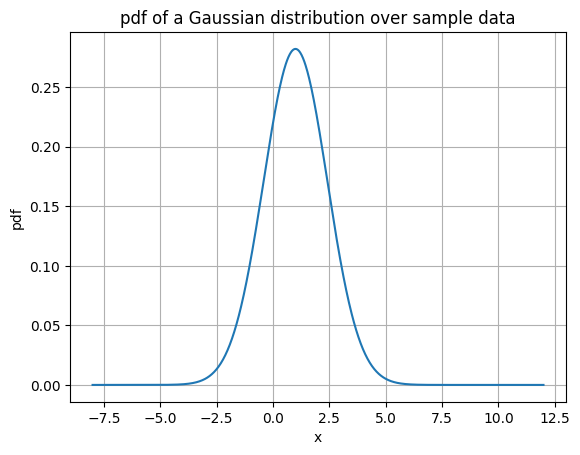

In [10]:
plt.figure()
#I use the exponential scale to plot the logpdf, so I end up plotting the exp(log(pdf)) = pdf
plt.plot(XPlot.ravel(), np.exp(logpdf_GAU_ND_Loop(XPlot, m, C)) )
plt.xlabel('x')
plt.ylabel('pdf')
plt.title('pdf of a Gaussian distribution over sample data')
plt.grid()
plt.show()


We can observer the classic *bell shape* of a Gaussian distributed random variable!

### Optimizing the `logpdf_GAU_ND(X, mu, C)` function to achieve a better complexity
The approach using the for loop can be a potential bottleneck if the dataset has a very large number of samples, because the complexity is linear to the number of samples. <br>
Broadcasting and re-arranging of the computations can be used in this case to significantly
speed up the computation of Y , and to avoid explicitly looping over the elements of X. 

The term toi optimize in order to avoid iterating through all the columns the key term in the multivariate Gaussian distribution (Beware: C = Σ is the Cov Matrix, later in the code I'll just write C instead of Σ for the seek of simplicity):
$$
(X - \mu)^T Σ^{-1} (X - \mu)
$$
Where:  
- $X$ is a matrix of **data points** with shape $(M, N)$, where $M$ is the number of features (dimensions) and $N$is the number of samples (data points).
- $\mu$  is the mean vector of the distribution with shape $(M,)$.
- $Σ$ is the **covariance matrix** with shape $(M, M)$, and $Σ^{-1}$ is its inverse.
I need to compute this term for each column of X. <br>
If i just write it like this, this operation will be wrong because it will result in an overall result of shape $(M, M)$ since the operation will be done element-wise. <br> 
**But my goal is to do it column wise!** <br>


I can rewrite it like this:
$$
(X-mu)^T  Σ^{-1}  (X-mu) = (X_{centered})^T  Σ^{-1}  X_{centered}
$$
Then:
### **Step-by-step Breakdown of the Matrix Operations**

1. **Multiplying by the inverse covariance matrix**:
   
   First, we multiply the inverse covariance matrix $C^{-1}$ of shape $(M, M)$ by the matrix $X_{\text{centered}}$ of shape $(M, N)$. The result will have shape $(M, N)$:

   $$
   C^{-1} X_{\text{centered}} \quad \text{will have shape} \quad (M, N)
   $$

2. **Transposing $X_{\text{centered}}$**:

   Next, we transpose $X_{\text{centered}}$, which changes its shape from $(M, N)$ to $(N, M)$:

   $$
   (X_{\text{centered}})^T \quad \text{will have shape} \quad (N, M)
   $$

3. **Element-wise multiplication**:

   We perform an element-wise multiplication of the two matrices:

   $$
   X_{\text{centered}}^T \cdot (C^{-1} X_{\text{centered}}) \quad \text{results in a matrix of shape} \quad (N, M)
   $$

   This is an element-wise multiplication between a matrix of shape $(N, M)$ and another matrix of shape $(M, N)$, producing a matrix with shape $(N, M)$.

4. **Summing over the rows**:

   Finally, we sum over the rows (axis=0) of the resulting matrix:

   $$
   \Sigma \left( X_{\text{centered}} \cdot (C^{-1} X_{\text{centered}}) \right) \quad \text{gives a vector of shape} \quad (N,)
   $$

   This sum collapses the matrix of shape $(N, M)$ into a 1D vector of shape $(N,)$, which contains the quadratic terms for each sample.

In [48]:
def logpdf_GAU_ND(X, mu, C):
    #Compute the log of the probability density function of a multivariate Gaussian distribution
    """
    Parameters
    - X: numpy array of shape (M, N) -> it contains multiple samples [x1, x2, ..., xN] having M features.
         X is a matrix of shape (M, N)!
    - mu: numpy array of shape (M,) -> mean of the distribution
    - C: numpy array of shape (M,M) -> covariance matrix of the distribution

    Returned values:
    - logpdf: float -> the log of the probability density function of the multivariate Gaussian distribution
    """

    #Attempt 2: Using vectorized operations, broadcasting, without loops
    #Let me think: matrix X has a shape of (M, N)...I need to compute the logpdf for each sample, so I need to compute the logpdf for each column of X
    #What can I do for achieving this without using a loop to scan all the columns of X?
    
  
    M = X.shape[0]  

    C_inv = np.linalg.inv(C)

    C_logDet = np.linalg.slogdet(C)[1]

    #The problems is related to the term; (X-mu).T @ C_inv @ (X-mu)
    #I need to compute this term for each column of X
    #If i Just write it like this, this operation will be wrong because will result in an overall result of shape (M, M) since the operation will be done element-wise 
    #But my goal is to do it column wise!
    #with (X-mu).T @ C_inv @ (X-mu) = (X_centered).T @ C_inv @ X_centered
    #I have: (M,N)⋅(M,M)⋅(M,N)⇒(N,M)⋅(M,N)=(N,N)
    #C_inv @ X_centered has a shape of (M, N)


    #Compute X centered using broadcasting 
    X_centered = X - mu #Shape (M, N)

    #print(f"Shape of X_centered: {X_centered.shape}")
  
    
    #I can obtain the same final shape of (N, N) by doing like this:
    #1. C_inv @ X_centered has a shape of (M, N)
    #2. X_centered.T has a shape of (N, M)
    #3. X_centered * (C_inv @ X_centered) is an element wise multiplication of two matrices of shape (M, N) and (N, M) and the result is a matrix of shape (N, M)
    #4. Then I can just sum over the columns (= I sum all the rows) of the resulting matrix to get a vector of shape (N,)
    
    quadratic_terms = np.sum(X_centered * (C_inv @ X_centered), axis=0)
    #print(f"Shape of quadratic_terms: {quadratic_terms.shape}")

    return (-0.5 * (M * np.log(2*np.pi) + C_logDet + quadratic_terms))



   
    

In [49]:
XPlot.shape

(1, 1000)

In [50]:

logpdf_GAU_ND(XPlot, m, C).shape

(1000,)

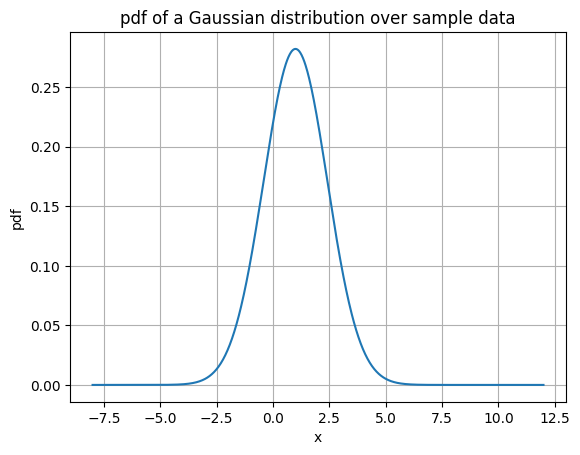

In [51]:
plt.figure()
#I use the exponential scale to plot the logpdf, so I end up plotting the exp(log(pdf)) = pdf
plt.plot(XPlot.ravel(), np.exp(logpdf_GAU_ND(XPlot, m, C)) )
plt.xlabel('x')
plt.ylabel('pdf')
plt.title('pdf of a Gaussian distribution over sample data')
plt.grid()
plt.show()